## 稀疏性和L1正则化
学习目标：
- 计算模型大小
- 通过L1正则化增加稀疏性，减小模型大小

使用正则化函数是一种降低复杂性的好方法，它会使权重正好为零。对于线性模型，权重为零就相当于完全没有使用相应特征。除了可避免过拟合之外，生成的模型会更加有效。

L1正则化是一种增加稀疏性的方法。

### 设置
加载加州住房数据集。

In [8]:
from __future__ import print_function

import math
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_df = pd.read_csv("https://download.mlcc.google.cn/mledu-datasets/california_housing_train.csv",
                                   sep=',')
california_housing_df = california_housing_df.reindex(np.random.permutation(california_housing_df.index))

In [9]:
# 预处理特征
def preprocess_features(california_housing_df):
    """预处理房价的DataFrame，准备输入特征,添加人为特征
    Args:
        california_housing_df: 包含加州房价数据的df
    Returns:
        包含处理后特征的DataFrame
    """
    selected_features = california_housing_df[["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
    processed_features = selected_features.copy()
    # 创建额外的特征
    processed_features["rooms_per_person"] = (california_housing_df["total_rooms"] / california_housing_df["population"])
    return processed_features

# 预处理目标，添加二值标签(房价是否高昂)作为目标
def preprocess_targets(california_housing_df):
    """从加州房价DataFrame准备目标特征，即标签
    Args:
        california_housing_dataframe: 包含加州房价数据的df
    Returns:
        包含目标标签的df
    """
    # 分类阈值
    value_threshold = 265000
    output_targets = pd.DataFrame()
    # 使用astype把布尔值转换为二值
    output_targets["median_house_value_is_high"] = (california_housing_df["median_house_value"] > value_threshold).astype(float)
    return output_targets


In [10]:
# 选择前12000/17000用于训练
training_examples = preprocess_features(california_housing_df.head(12000))
training_targets = preprocess_targets(california_housing_df.head(12000))

# 选择最后的5000用于验证
validation_examples = preprocess_features(california_housing_df.tail(5000))
validation_targets = preprocess_targets(california_housing_df.tail(5000))

print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.6,2636.0,538.0,1429.5,500.2,3.9,2.0
std,2.1,2.0,12.7,2127.4,414.1,1144.7,377.2,1.9,1.2
min,32.5,-124.3,1.0,2.0,1.0,6.0,1.0,0.5,0.1
25%,33.9,-121.8,18.0,1462.0,296.0,793.0,281.0,2.6,1.5
50%,34.3,-118.5,29.0,2125.5,434.0,1171.0,408.0,3.5,1.9
75%,37.7,-118.0,37.0,3166.0,648.0,1724.0,604.2,4.8,2.3
max,42.0,-114.3,52.0,32627.0,6445.0,35682.0,6082.0,15.0,55.2


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.5,28.5,2662.0,542.8,1429.7,503.7,3.9,2.0
std,2.1,2.0,12.4,2301.2,438.9,1155.6,401.6,1.9,1.1
min,32.6,-124.3,1.0,12.0,3.0,3.0,2.0,0.5,0.0
25%,33.9,-121.8,18.0,1460.5,298.0,781.8,282.0,2.6,1.5
50%,34.2,-118.5,29.0,2135.0,434.0,1157.0,410.0,3.6,2.0
75%,37.7,-118.0,37.0,3118.2,649.0,1714.2,607.0,4.8,2.3
max,42.0,-114.5,52.0,37937.0,5471.0,16122.0,5189.0,15.0,29.4


Training targets summary:


,median_house_value_is_high
count,12000.0
mean,0.3
std,0.4
min,0.0
25%,0.0
50%,0.0
75%,1.0
max,1.0


Validation targets summary:


,median_house_value_is_high
count,5000.0
mean,0.2
std,0.4
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,1.0


In [11]:
def my_input_fn(features, targets, batch_size=1,shuffle=True, num_epochs=None):
    """使用多个特征训练一个线性回归器
    Args:
        features: 特征的DataFrame
        targets: 目标的DataFrame
        batch_size: 传递给模型的批大小
        shuffle: 是否打乱数据
        num_epochs: 数据重复的epochs数
    Returns:
        下一批数据元组(features, labels)
    """
    # 转换DataFrame到numpy数组
    features = {key:np.array(value) for key,value in dict(features).items()}
    
    # 构建数据集
    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # 打乱数据
    if shuffle:
        ds = ds.shuffle(10000)
        
    # 返回下一批数据
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [12]:
# 根据分位数计算边界，使每个分桶包含相同数量的元素
def get_quantile_based_boundaries(feature_values, num_buckets):
    boundaries = np.arange(1.0, num_buckets) / num_buckets
    quantiles = feature_values.quantile(boundaries)
    return [quantiles[q] for q in quantiles.keys()]

In [27]:
def construct_bucketized_feature_columns():
    """构建TensorFlow特征列
    Returns:
        特征列集合
    """
    households = tf.feature_column.numeric_column("households")
    longitude = tf.feature_column.numeric_column("longitude")
    latitude = tf. feature_column.numeric_column("latitude")
    total_rooms = tf.feature_column.numeric_column("total_rooms")
    total_bedrooms = tf.feature_column.numeric_column("total_bedrooms")
    population = tf.feature_column.numeric_column("population")
    housing_median_age = tf.feature_column.numeric_column("housing_median_age")
    median_income = tf.feature_column.numeric_column("median_income")
    rooms_per_person = tf.feature_column.numeric_column("rooms_per_person")
    
    bucketized_households = tf.feature_column.bucketized_column(
        households, boundaries=get_quantile_based_boundaries(
        training_examples["households"], 10))
    bucketized_longitude = tf.feature_column.bucketized_column(
        longitude, boundaries=get_quantile_based_boundaries(
        training_examples["longitude"], 50))
    bucketized_latitude = tf.feature_column.bucketized_column(
        latitude, boundaries=get_quantile_based_boundaries(
        training_examples["latitude"], 50))
    bucketized_total_rooms = tf.feature_column.bucketized_column(
        total_rooms,boundaries=get_quantile_based_boundaries(
        training_examples["total_rooms"], 10))
    bucketized_total_bedrooms = tf.feature_column.bucketized_column(
        total_bedrooms, boundaries=get_quantile_based_boundaries(
        training_examples["total_bedrooms"], 10))
    bucketized_population = tf.feature_column.bucketized_column(
        population, boundaries=get_quantile_based_boundaries(
        training_examples["population"], 10))
    bucketized_housing_median_age = tf.feature_column.bucketized_column(
        housing_median_age, boundaries=get_quantile_based_boundaries(
        training_examples["housing_median_age"], 10))
    bucketized_median_income = tf.feature_column.bucketized_column(
        median_income, boundaries=get_quantile_based_boundaries(
        training_examples["median_income"], 10))
    bucketized_rooms_per_person = tf.feature_column.bucketized_column(
        rooms_per_person, boundaries=get_quantile_based_boundaries(
        training_examples["rooms_per_person"], 10))
    long_x_lat = tf.feature_column.crossed_column(
        set([bucketized_longitude, bucketized_latitude]), hash_bucket_size=1000)
    
    feature_columns = set([
    long_x_lat,
    bucketized_longitude,
    bucketized_latitude,
    bucketized_total_rooms,
    bucketized_total_bedrooms,
    bucketized_housing_median_age,
    bucketized_households,
    bucketized_median_income,
    bucketized_rooms_per_person])
    
    return feature_columns

### 计算模型大小
要计算模型大小，需计算非零参数的数量。我们构造一个辅助函数，函数使用了Estimator的API。

In [28]:
def model_size(estimator):
    variables = estimator.get_variable_names()
    size = 0
    for variable in variables:
        # 排除这些变量名
        if not any(x in variable for x in ['global_step',
                                           'centered_bias_weight',
                                           'bias_weight',
                                           'Ftrl']):
            size += np.count_nonzero(estimator.get_variable_value(variable))
    return size

### 减小模型大小
现在团队要求我们构建一个准确度高的逻辑回归模型，可以告诉我们街区的住房成本是否高昂。

团队要求模型的**参数数量不超过600个**，且对测试集的**对数损失函数低于0.35**，否则不能发布该模型。

#### 任务1.查找合适的正则化系数。
查找满足上述要求的正则化强度系数。

In [29]:
def train_linear_classifier_model(
                learning_rate,
                regularization_strength,
                steps, 
                batch_size, 
                feature_columns,
                training_examples, 
                training_targets, 
                validation_examples, 
                validation_targets):
    """使用多个特征训练一个线性回归模型
    """
    periods = 10
    steps_per_period = steps / periods
    
    # 定义优化器,并加入L1正则化
    my_optimizer = tf.train.FtrlOptimizer(learning_rate=learning_rate,
                                                     l1_regularization_strength=regularization_strength)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    # 创建一个线性回归器
    linear_regressor = tf.estimator.LinearClassifier(feature_columns=feature_columns, 
                                                    optimizer=my_optimizer)
    
    # 创建输入函数
    training_input_fn = lambda: my_input_fn(training_examples,training_targets["median_house_value_is_high"], batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(training_examples, training_targets["median_house_value_is_high"], num_epochs=1, shuffle=False)
    predict_validation_input_fn = lambda: my_input_fn(validation_examples, validation_targets["median_house_value_is_high"], num_epochs=1, shuffle=False)
    
    # 训练模型，并在每个周期输出loss
    print("Start training...")
    print("Log loss (on training data): ")
    training_rmse = []
    validation_rmse = []
    for period in range(0, periods):
        linear_regressor.train(input_fn=training_input_fn, steps=steps_per_period)
        
        # 计算预测
        training_probabilities = linear_regressor.predict(input_fn=predict_training_input_fn)
        training_probabilities = np.array([item["probabilities"] for item in training_probabilities])
        validation_probabilities = linear_regressor.predict(input_fn=predict_validation_input_fn)
        validation_probabilities = np.array([item["probabilities"] for item in validation_probabilities])
        
        # 计算训练和验证的损失
        training_log_loss = metrics.log_loss(training_targets, training_probabilities)
        validation_log_loss = metrics.log_loss(validation_targets, validation_probabilities)
        
        # 输出结果
        print("period %02d : %.2f" % (period, training_log_loss))
        training_rmse.append(training_log_loss)
        validation_rmse.append(validation_log_loss)
    print("Model training finished!")
    
    # 损失随周期变化图
    plt.ylabel("Log Loss")
    plt.xlabel("Periods")
    plt.title("Log Loss via Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validaiton")
    plt.legend()
    
    return linear_regressor

Start training...
Log loss (on training data): 
period 00 : 0.30
period 01 : 0.26
period 02 : 0.25
period 03 : 0.24
period 04 : 0.24
period 05 : 0.23
period 06 : 0.23
period 07 : 0.23
period 08 : 0.22
period 09 : 0.22
Model training finished!
Model size: 707


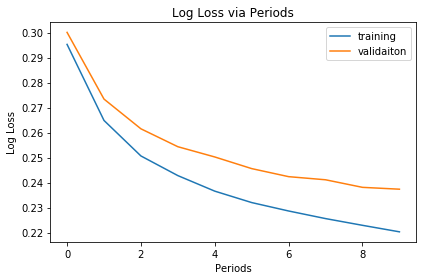

In [31]:
# 正则化强度为 0.1 应该就足够了。
# 请注意，有一个需要做出折中选择的地方：正则化越强，我们获得的模型就越小，但会影响分类损失。
linear_classifier = train_linear_classifier_model(
    learning_rate=0.1,
    regularization_strength=0.25,
    steps=600,
    batch_size=100,
    feature_columns=construct_bucketized_feature_columns(),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)
print("Model size:", model_size(linear_classifier))